In [ ]:
import torch
from src.models.world_model import WorldModel
from src.data.dataset import get_dataloader
from src.evaluation.rollout_eval import evaluate_rollout

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 建立和训练时一致的模型
model = WorldModel(input_dim=10, latent_dim=256).to(device)

# 2. 读取 checkpoint（注意 map_location）
ckpt_path = r'checkpoints\world_model\checkpoint_epoch_100.pt'
checkpoint = torch.load(ckpt_path, map_location=device)

# 3. 只把其中的 model_state_dict 加载进模型
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("✅ 模型参数加载成功")

# 4. 准备测试数据
test_loader = get_dataloader(
    data_path='data/processed/test_episodes.npz',
    batch_size=16,
    shuffle=False,
    normalize=True,
    stats_path=None  # 如果你有训练集 stats，可以在这里传路径
)

# 5. 调用评估函数
metrics = evaluate_rollout(
    model=model,
    data_loader=test_loader,
    context_length=10,
    rollout_length=20,
    device=device
)

print(metrics)


✅ 模型参数加载成功
Normalization stats computed:
  Mean: tensor([ 1.8884e+03,  1.0579e+03, -2.3266e+01, -4.4948e-02,  1.1143e+00,
         1.0182e+00,  1.0092e+01,  7.3928e-01,  7.4333e-01,  0.0000e+00])
  Std: tensor([9.0302e+02, 2.0115e+02, 1.9688e+02, 5.3813e+01, 1.3499e+00, 2.1915e-01,
        5.4722e+00, 4.3903e-01, 4.3679e-01, 1.0000e-06])
Loaded 558 episodes
Shape: T=30, K=50, F=10


Evaluating Rollout:   0%|                                                                       | 0/35 [00:00<?, ?it/s]C:\software\anaconda\Lib\site-packages\torch\nn\modules\transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:179.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
C:\software\anaconda\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(
Evaluating Rollout: 100%|██████████████████████████████████████████████████████████████| 35/35 [00:03<00:00,  9.62it/s]

{'ade': 0.7707908630371094, 'fde': 0.7837532690593174, 'velocity_error': 0.5242464227335794, 'heading_error': 40.52766789027623, 'collision_rate': 91.2643967888762}


Will plot 8 agents: [0 1 2 3 4 5 6 7]


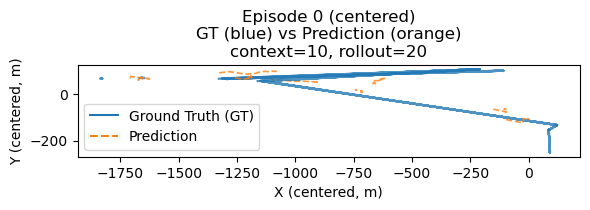

✅ 图像已保存到: plots/episode0_rollout_centered_few_agents.png


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os

os.makedirs("plots", exist_ok=True)

# ========= 1. 反归一化后的坐标（沿用你前面算好的） =========
# pred_states_real, target_states_real: [1, R, K, F]
gt_xy   = target_states_real[0, :, :, 0:2].numpy()   # [R, K, 2]
pred_xy = pred_states_real[0, :, :, 0:2].numpy()     # [R, K, 2]

gt_mask   = target_masks[0].cpu().numpy() > 0.5      # [R, K]
pred_mask = pred_masks[0].cpu().numpy() > 0.5        # [R, K]

R, K = gt_mask.shape

# ========= 2. 把坐标平移到“场景中心” =========
# 用数据整体的 mean 当近似场景中心
center = np.array([
    dataset.mean[0].item(),  # x mean
    dataset.mean[1].item(),  # y mean
])

gt_xy_centered   = gt_xy   - center  # [R, K, 2]
pred_xy_centered = pred_xy - center  # [R, K, 2]

# ========= 3. 只选一部分“轨迹比较完整”的车辆 =========
min_points = 5  # 至少出现这么多帧才画
valid_counts = gt_mask.sum(axis=0)   # [K]
agent_ids = np.where(valid_counts >= min_points)[0]

# 最多画 8 辆车，避免太乱
max_agents_to_plot = 8
agent_ids = agent_ids[:max_agents_to_plot]

print(f"Will plot {len(agent_ids)} agents:", agent_ids)

# ========= 4. 画图：GT (蓝色实线) vs Pred (橙色虚线) =========
plt.figure(figsize=(6, 6))

for k_idx in agent_ids:
    gt_valid   = gt_mask[:, k_idx]
    pred_valid = pred_mask[:, k_idx]

    # Ground Truth - 蓝色实线
    if gt_valid.sum() >= min_points:
        plt.plot(
            gt_xy_centered[gt_valid, k_idx, 0],
            gt_xy_centered[gt_valid, k_idx, 1],
            color="C0",
            linewidth=1.5,
            alpha=0.8,
        )

    # Prediction - 橙色虚线
    if pred_valid.sum() >= min_points:
        plt.plot(
            pred_xy_centered[pred_valid, k_idx, 0],
            pred_xy_centered[pred_valid, k_idx, 1],
            color="C1",
            linestyle="--",
            linewidth=1.2,
            alpha=0.8,
        )

plt.xlabel("X (centered, m)")
plt.ylabel("Y (centered, m)")
plt.title(
    f"Episode {example_idx} (centered)\n"
    f"GT (blue) vs Prediction (orange)\n"
    f"context={context_length}, rollout={rollout_length}"
)
plt.gca().set_aspect("equal", adjustable="box")

legend_elements = [
    Line2D([0], [0], color="C0", lw=1.5, label="Ground Truth (GT)"),
    Line2D([0], [0], color="C1", lw=1.5, linestyle="--", label="Prediction"),
]
plt.legend(handles=legend_elements, loc="best")

save_path = "plots/episode0_rollout_centered_few_agents.png"
plt.tight_layout()
plt.savefig(save_path, dpi=200)
plt.show()

print(f"✅ 图像已保存到: {save_path}")


In [1]:
import torch
import numpy as np
from src.models.world_model import WorldModel
from src.data.dataset import get_dataloader
from src.evaluation.visualization import (
    visualize_trajectories,
    visualize_rollout,
    create_animation,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 1. 加载模型 ====
ckpt_path = r"src/training/checkpoints/checkpoint_epoch_100.pt"
model = WorldModel(input_dim=10, latent_dim=256).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
print("✅ 模型加载完成")

# ==== 2. 加载测试数据 ====
test_loader = get_dataloader(
    data_path="data/processed/test_episodes.npz",
    batch_size=16,
    shuffle=False,
    normalize=True,   # 和训练保持一致
    stats_path=None,
)
dataset = test_loader.dataset
mean = dataset.mean.view(1, 1, 1, -1)   # [1,1,1,F]
std  = dataset.std.view(1, 1, 1, -1)

context_length = 10
rollout_length = 20

# 取一个 batch（可以多个 batch 一起可视化）
batch = next(iter(test_loader))
states = batch["states"].to(device)   # [B, 30, 50, 10] 标准化
masks  = batch["masks"].to(device)   # [B, 30, 50]

# 取 context 和 target
context_states = states[:, :context_length]                       # [B, C, K, F]
context_masks  = masks[:, :context_length]                        # [B, C, K]
target_states  = states[:, context_length:context_length+rollout_length]  # [B, R, K, F]
target_masks   = masks[:, context_length:context_length+rollout_length]   # [B, R, K]

# ==== 3. 用 world model 做 rollout ====
with torch.no_grad():
    rollout_out = model.rollout(
        initial_states=context_states,
        initial_masks=context_masks,
        n_steps=rollout_length,
        teacher_forcing=False,
        ground_truth_states=None,
    )

pred_states_norm = rollout_out["predicted_states"]  # [B, R, K, F]
pred_masks       = rollout_out["predicted_masks"]   # [B, R, K]

# ==== 4. 反归一化到“真实坐标”（可选，但推荐） ====
pred_states_real   = pred_states_norm.cpu() * std + mean   # [B, R, K, F]
target_states_real = target_states.cpu()      * std + mean # [B, R, K, F]

# 只要 x,y 两个坐标就够了：[..., 0:2]
pred_np = pred_states_real[..., 0:2].numpy()    # [B, R, K, 2]
gt_np   = target_states_real[..., 0:2].numpy()  # [B, R, K, 2]
mask_np = target_masks.cpu().numpy().astype(bool)  # [B, R, K]


✅ 模型加载完成
Normalization stats computed:
  Mean: tensor([ 1.8884e+03,  1.0579e+03, -2.3266e+01, -4.4948e-02,  1.1143e+00,
         1.0182e+00,  1.0092e+01,  7.3928e-01,  7.4333e-01,  0.0000e+00])
  Std: tensor([9.0302e+02, 2.0115e+02, 1.9688e+02, 5.3813e+01, 1.3499e+00, 2.1915e-01,
        5.4722e+00, 4.3903e-01, 4.3679e-01, 1.0000e-06])
Loaded 558 episodes
Shape: T=30, K=50, F=10


C:\software\anaconda\Lib\site-packages\torch\nn\modules\transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\NestedTensorImpl.cpp:179.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
C:\software\anaconda\Lib\site-packages\torch\nn\modules\transformer.py:685: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._transformer_encoder_layer_fwd(


In [2]:
from src.evaluation.visualization import visualize_rollout

visualize_rollout(
    predicted=pred_np,          # [B, R, K, 2]
    ground_truth=gt_np,
    masks=mask_np,
    save_path="plots/rollout_comparison.png",
)
print("✅ rollout_comparison.png 已保存")


✅ rollout_comparison saved to plots/rollout_comparison.png
✅ rollout_comparison.png 已保存
